In [6]:
from ultralytics import YOLO
import numpy as np
import cv2

model = YOLO('yolov8l.pt')
img_path = 'test.jpg'

r = model.predict(img_path)

Ultralytics YOLOv8.0.48 🚀 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv8l summary (fused): 268 layers, 43668288 parameters, 0 gradients, 165.2 GFLOPs

image 1/1 /home/cemmi/Documents/aicrowd/G-Universal-CLIP/test.jpg: 640x512 1 person, 10.1ms
Speed: 0.2ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
results = model.predict(img_path)

loc = []
conf = []
cls = []
for result in results:
    # detection
    loc = result.boxes.xyxy.detach().cpu().numpy().astype(int)   # box with xyxy format, (N, 4)
    conf = np.squeeze(result.boxes.conf.detach().cpu().numpy())   # confidence score, (N, 1)
    cls = np.squeeze(result.boxes.cls.detach().cpu().numpy())    # cls, (N, 1)

loc, conf, cls


image 1/1 /home/cemmi/Documents/aicrowd/G-Universal-CLIP/test.jpg: 640x512 1 person, 9.7ms
Speed: 10.9ms preprocess, 9.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


(array([[  0,   1, 719, 949]]),
 array(    0.94315, dtype=float32),
 array(          0, dtype=float32))

In [26]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

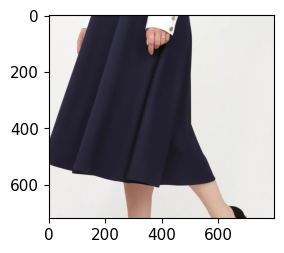

In [28]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 1)
plt.imshow(img[loc[0][0]:loc[0][2], loc[0][1]:loc[0][3]])

In [1]:
import pandas as pd
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import utilities
import cv2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import timm
import math
from transformers import (get_linear_schedule_with_warmup, 
                          get_cosine_schedule_with_warmup, 
                          get_cosine_with_hard_restarts_schedule_with_warmup,
                          get_constant_schedule_with_warmup)
from tqdm import tqdm
import faiss
import random
import gc
import transformers
from transformers import CLIPProcessor, CLIPVisionModel,  CLIPVisionConfig
from PIL import Image
from torchvision import transforms
from pytorch_metric_learning import losses
import open_clip
import sys
import os
import time
import torch.onnx

%load_ext autoreload
%autoreload 2

In [2]:
class Head_Slim(nn.Module):
    def __init__(self, hidden_size):
        super(Head_Slim, self).__init__()

        self.emb = nn.Linear(hidden_size, 512, bias=False)
        self.dropout = nn.Dropout(.1)
        self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])

    def forward(self, x):
        x = self.dropout(x)
        x_1 = self.emb(self.dropouts[0](x))
        x_2 = self.emb(self.dropouts[1](x))
        x_3 = self.emb(self.dropouts[2](x))
        x_4 = self.emb(self.dropouts[3](x))
        x_5 = self.emb(self.dropouts[4](x))

        return F.normalize((x_1 + x_2 + x_3 + x_4 + x_5) / 5.0)

class Model_Slim(nn.Module):
    def __init__(self, vit_backbone):
        super(Model_Slim, self).__init__()
        self.encoder = vit_backbone.visual
        self.head = Head_Slim(1024)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)


In [3]:
vit_backbone, _, _ = open_clip.create_model_and_transforms('ViT-H-14', None)
model = Model_Slim(vit_backbone)
model.load_state_dict(torch.load("./my_experiments/vit_h_224_products-10k/model_best_epoch_0_mAP3_0.53_slim.pt"))
model.eval()
model.half()

model_ = torch.jit.script(model)
# model.to('cuda')
# print()

In [4]:
model_ = model_.to('cuda')
next(model_.parameters()).is_cuda

True

In [5]:
dummy_input = torch.randn(1, 3, 224, 224, dtype=torch.float16)
dummy_input = dummy_input.to('cuda')
dummy_input.is_cuda

True

In [ ]:
torch.onnx.export(
    model_, 
    dummy_input, 
    "./my_experiments/dmy/model_best_epoch_0_mAP3_0.53_slim_.onnx", 
    opset_version = 15,
    verbose=True)

In [ ]:
import onnx

# Load the ONNX model
model = onnx.load("./my_experiments/dmy/model_best_epoch_0_mAP3_0.53_slim.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

In [15]:
import torch
import torch_tensorrt

import open_clip
import utilities
import torch.nn as nn
import torch.nn.functional as F

class Head_Slim(nn.Module):
    def __init__(self, hidden_size):
        super(Head_Slim, self).__init__()

        self.emb = nn.Linear(hidden_size, 512, bias=False)
        self.dropout = nn.Dropout(.1)
        self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])

    def forward(self, x):
        x = self.dropout(x)
        x_1 = self.emb(self.dropouts[0](x))
        x_2 = self.emb(self.dropouts[1](x))
        x_3 = self.emb(self.dropouts[2](x))
        x_4 = self.emb(self.dropouts[3](x))
        x_5 = self.emb(self.dropouts[4](x))

        return F.normalize((x_1 + x_2 + x_3 + x_4 + x_5) / 5.0)

class Model_Slim(nn.Module):
    def __init__(self, vit_backbone):
        super(Model_Slim, self).__init__()
        self.encoder = vit_backbone.visual
        self.head = Head_Slim(1024)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

    
vit_backbone, _, _ = open_clip.create_model_and_transforms('ViT-H-14', None)
model_fx = Model_Slim(vit_backbone)
# model_fx.load_state_dict(torch.load("./my_experiments/vit_h_224_products-10k/model_best_epoch_0_mAP3_0.53_slim.pt"))
model_fx.eval()
model_fx.half()
# /

input_data = torch.randn(1, 3, 224, 224, dtype=torch.float16)
input_data = input_data.to('cuda')
# input_data.is_cuda

inputs = [
    torch_tensorrt.Input(
        min_shape=[1, 3, 224, 224],
        opt_shape=[1, 3, 224, 224],
        max_shape=[512, 3,224, 224],
        dtype=torch.half,
    )
]
enabled_precisions = {torch.float, torch.half}  # Run with fp16

trt_ts_module = torch_tensorrt.compile(
    model_fx, inputs=inputs, enabled_precisions=enabled_precisions
)

input_data = input_data.to("cuda").half()
result = trt_ts_module(input_data)
torch.jit.save(trt_ts_module, "trt_ts_module.ts")

INFO:root:Loaded ViT-H-14 model config.


RuntimeError: outputs_[i]->uses().empty() INTERNAL ASSERT FAILED at "../torch/csrc/jit/ir/ir.cpp":1309, please report a bug to PyTorch. 

In [ ]:
import pandas as pd
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import utilities
import cv2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import timm
import math
from transformers import (get_linear_schedule_with_warmup, 
                          get_cosine_schedule_with_warmup, 
                          get_cosine_with_hard_restarts_schedule_with_warmup,
                          get_constant_schedule_with_warmup)
from tqdm import tqdm
import faiss
import random
import gc
import transformers
from transformers import CLIPProcessor, CLIPVisionModel,  CLIPVisionConfig
from PIL import Image
from torchvision import transforms
from pytorch_metric_learning import losses
import open_clip
import sys
import os
import time
import torch.onnx

class Head_Slim(nn.Module):
    def __init__(self, hidden_size):
        super(Head_Slim, self).__init__()

        self.emb = nn.Linear(hidden_size, 512, bias=False)
        self.dropout = utilities.Multisample_Dropout()

    def forward(self, x):
        embeddings = self.dropout(x, self.emb)

        return F.normalize(embeddings)

class Model_Slim(nn.Module):
    def __init__(self, vit_backbone):
        super(Model_Slim, self).__init__()
        self.encoder = vit_backbone.visual
        self.head = Head_Slim(1024)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

vit_backbone, _, _ = open_clip.create_model_and_transforms('ViT-H-14', None)
model = Model_Slim(vit_backbone)
model.load_state_dict(torch.load("./my_experiments/vit_h_224_products-10k/model_best_epoch_0_mAP3_0.53_slim.pt"))
model.eval()
model.cuda()
# model.half()

input = torch.randn(1, 3, 224, 224, requires_grad=False, device='cuda')
torch.onnx.export(
    model, 
    input, 
    "./my_experiments/dmy/model_best_epoch_0_mAP3_0.53_slim.onnx", 
    input_names=["input"],
    output_names=["output"],
    verbose=True,
    export_params=True)